### **Análisis de Ventas De Una Empresa De Productos Tecnológicos**

Este proyecto realiza un análisis integral de los datos de ventas y envíos de una empresa dedicada a la comercialización y distribución de productos Tecnológicos.
A partir de archivos CSV, se emplean herramientas de Python, como Pandas y Matplotlib, para procesar, visualizar y comprender la información clave del negocio.

Los principales indicadores analizados incluyen:

* Rendimiento general de ventas
* Rubros más rentables
* Clientes con mayor volumen de compra
* Evolución mensual de las ventas
* Productos más vendidos
* Promedio de reseñas y desempeño de envíos

El objetivo de este análisis es ofrecer una visión clara, precisa y visualmente informativa del rendimiento comercial, facilitando la toma de decisiones estratégicas basadas en datos.

**Carga de datos**


Primero se importan las librerías necesarias y se cargan los archivos CSV desde la carpeta “csv de ventas”, que contiene toda la información del sistema (clientes, facturas, productos, rubros, detalles de facturas y reseña).

Tienen que existir los cvs en la carpeta "csv de ventas".

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

base_path = "csv de ventas_2025/"

archivos = ["cliente.csv", "factura.csv", "detalle_factura.csv", "producto.csv", "rubro.csv", "reseña.csv"]
faltantes = [f for f in archivos if not os.path.exists(os.path.join(base_path, f))]

if faltantes:
    mensaje = "❌ ERROR: No se encontraron los siguientes archivos requeridos:\n"
    for f in faltantes:
        mensaje += f"   - {f}\n"
    mensaje += "\n Revisá la carpeta 'csv de ventas_2025' antes de ejecutar el análisis."
    raise FileNotFoundError(mensaje)
else:
    # Cargar los CSV una sola vez si todos existen
    clientes = pd.read_csv(base_path + "cliente.csv")
    facturas = pd.read_csv(base_path + "factura.csv")
    detalle = pd.read_csv(base_path + "detalle_factura.csv")
    productos = pd.read_csv(base_path + "producto.csv")
    rubros = pd.read_csv(base_path + "rubro.csv")
    reseñas = pd.read_csv(base_path + "reseña.csv")

**Preparación de los datos**


Se combinan las tablas mediante sus claves para crear un único DataFrame que contenga toda la información consolidada.
Además, se calcula el subtotal de cada producto y se formatea la fecha correctamente.

In [2]:
df = detalle.merge(productos, on="id_producto", how="left")
df = df.merge(rubros, on="id_rubro", how="left")
df = df.merge(facturas, on="id_factura", how="left")
df = df.merge(clientes, on="id_cliente", how="left")

df = df.merge(reseñas[['id_factura', 'puntaje', 'fecha_reseña']], on="id_factura", how="left")

df["subtotal"] = df["cantidad"] * df["precio_unitario"]
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
df["fecha_reseña"] = pd.to_datetime(df["fecha_reseña"], errors="coerce")


**Cálculo de métricas generales**

Se obtienen los valores globales del sistema:

* Total de ventas realizadas
* Cantidad de facturas
* Número de clientes únicos
* Total de productos vendidos

Además, se calculan las unidades vendidas por producto.

In [3]:
total_ventas = df["subtotal"].sum()
total_facturas = df["id_factura"].nunique()
total_clientes = df["id_cliente"].nunique()
total_productos = df["id_producto"].nunique()

ventas_cantidad = df.groupby("descripcion")["cantidad"].sum().sort_values(ascending=False)

**Métricas principales**

Se visualizan los indicadores más importantes de la empresa, incluyendo el total de ventas, facturas emitidas, clientes activos y el producto más vendido.

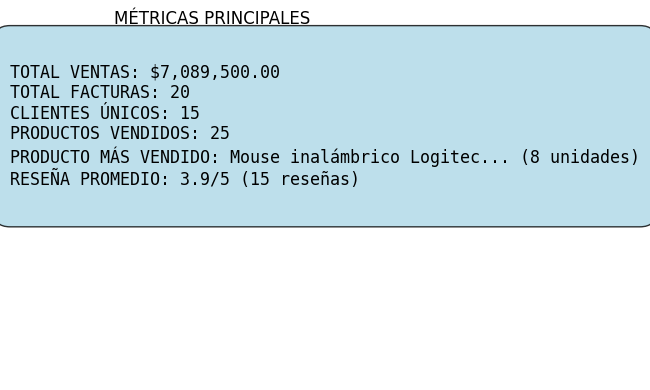

In [4]:
reseñas["fecha_reseña"] = pd.to_datetime(reseñas["fecha_reseña"], errors="coerce")
reseñas_unicas_2025 = reseñas[reseñas["fecha_reseña"].dt.year == 2025]

reseña_promedio = reseñas_unicas_2025['puntaje'].mean() if not reseñas_unicas_2025.empty else 0
total_reseñas_texto = len(reseñas_unicas_2025) if not reseñas_unicas_2025.empty else 0

plt.figure(figsize=(6, 4))
producto_mas_vendido = ventas_cantidad.index[0]
cantidad_mas_vendido = ventas_cantidad.values[0]

metricas_texto = f"""
TOTAL VENTAS: ${total_ventas:,.2f}
TOTAL FACTURAS: {total_facturas}
CLIENTES ÚNICOS: {total_clientes}
PRODUCTOS VENDIDOS: {total_productos}
PRODUCTO MÁS VENDIDO: {producto_mas_vendido[:25]}... ({cantidad_mas_vendido} unidades)
RESEÑA PROMEDIO: {reseña_promedio:.1f}/5 ({total_reseñas_texto} reseñas)
"""

plt.axis('off')
plt.text(0, 0.5, metricas_texto, fontsize=12, fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=1", facecolor="lightblue", alpha=0.8))
plt.title("MÉTRICAS PRINCIPALES")
plt.tight_layout()
plt.show()

**Ventas por rubro**

Muestra los rubros con mayor monto total de ventas, permitiendo identificar qué áreas del negocio son más rentables.

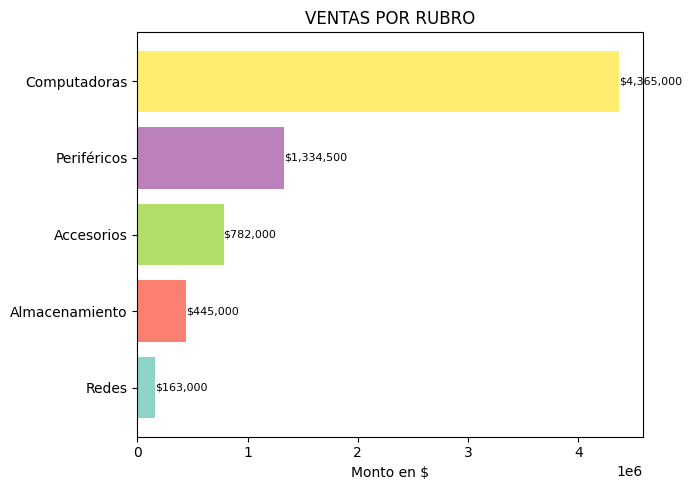

In [5]:
ventas_rubro = df.groupby("nombre_rubro")["subtotal"].sum().sort_values(ascending=True)

plt.figure(figsize=(7, 5))
colors_rubro = plt.cm.Set3(np.linspace(0, 1, len(ventas_rubro)))
bars = plt.barh(ventas_rubro.index, ventas_rubro.values, color=colors_rubro)

plt.title("VENTAS POR RUBRO")
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'${bar.get_width():,.0f}', va='center', fontsize=8)
plt.xlabel("Monto en $")
plt.tight_layout()
plt.show()


**Top clientes**

Se listan los clientes más importantes de la empresa según el monto total de compras realizadas.

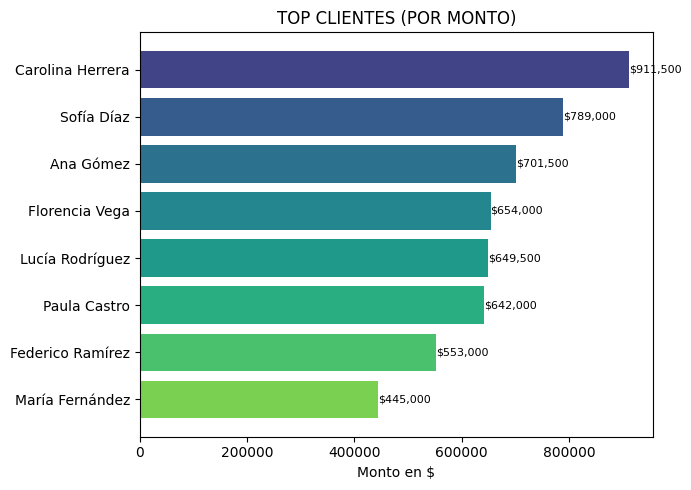

In [6]:
top_clientes = df.groupby("nombre")["subtotal"].sum().sort_values(ascending=False).head(8)

plt.figure(figsize=(7, 5))
colors_clientes = plt.cm.viridis(np.linspace(0.2, 0.8, len(top_clientes)))
bars = plt.barh(top_clientes.index, top_clientes.values, color=colors_clientes)

plt.title("TOP CLIENTES (POR MONTO)")
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'${bar.get_width():,.0f}', va='center', fontsize=8)
plt.xlabel("Monto en $")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


**Evolución mensual de ventas**

Analiza cómo varían las ventas mes a mes durante el año 2025, mostrando los picos y caídas en el rendimiento comercial.

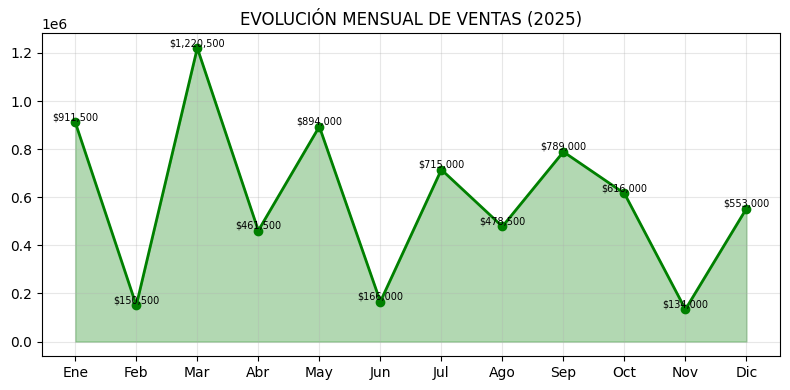

In [7]:
df_2025 = df[df["fecha"].dt.year == 2025]
ventas_2025_mes = df_2025.groupby(df_2025["fecha"].dt.month)["subtotal"].sum().reindex(range(1,13), fill_value=0)
meses = ["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dic"]

plt.figure(figsize=(8, 4))
plt.fill_between(range(1,13), ventas_2025_mes.values, alpha=0.3, color='green')
plt.plot(range(1,13), ventas_2025_mes.values, marker='o', color='green', linewidth=2)
plt.xticks(range(1,13), meses)
plt.grid(True, alpha=0.3)
plt.title("EVOLUCIÓN MENSUAL DE VENTAS (2025)")
for i, valor in enumerate(ventas_2025_mes.values):
    if valor > 0:
        plt.text(i+1, valor, f'${valor:,.0f}', ha='center', va='bottom', fontsize=7)
plt.tight_layout()
plt.show()


**Productos más vendidos**

Muestra los 10 productos con mayor cantidad de unidades vendidas, permitiendo identificar los artículos más populares.

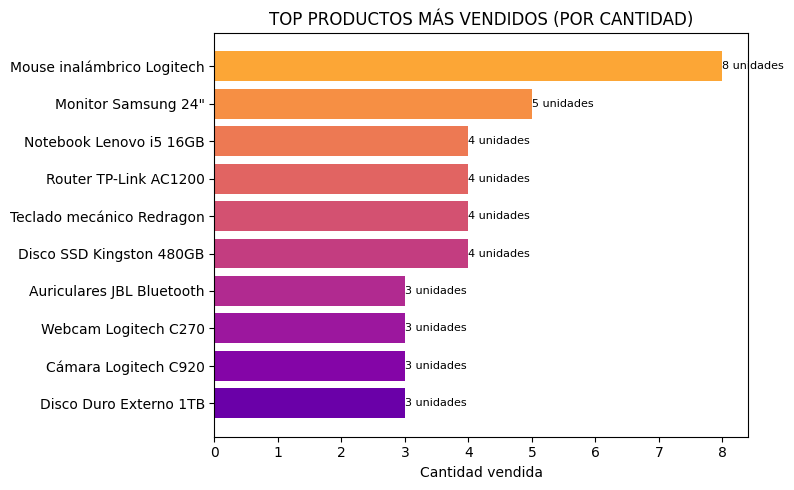

In [8]:
top_productos_cantidad = ventas_cantidad.head(10).sort_values(ascending=True)

plt.figure(figsize=(8, 5))
colors_productos = plt.cm.plasma(np.linspace(0.2, 0.8, len(top_productos_cantidad)))
bars = plt.barh(top_productos_cantidad.index, top_productos_cantidad.values, color=colors_productos)

plt.title("TOP PRODUCTOS MÁS VENDIDOS (POR CANTIDAD)")
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.0f} unidades', va='center', fontsize=8)
plt.xlabel("Cantidad vendida")
plt.tight_layout()
plt.show()

**Reseñas de Envíos**

Analiza las reseñas de envíos correspondientes al año 2025, mostrando la evolución mensual del puntaje promedio y la cantidad de reseñas recibidas.
El gráfico combina una línea (puntaje promedio) y barras (cantidad de reseñas), permitiendo identificar tendencias de satisfacción y periodos de mayor actividad.

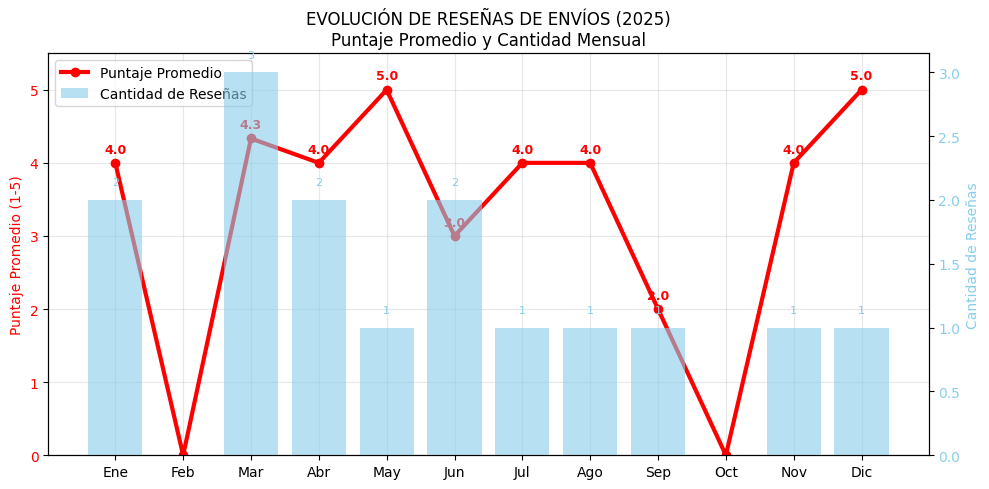


 MÉTRICAS DE RESEÑAS DE ENVÍOS:
   • Puntaje Promedio General: 3.93/5
   • Total de Reseñas Recibidas: 15
   • Mejor Mes: May (5.00/5)
   • Mes a Mejorar: Sep (2.00/5)


In [9]:
reseñas["fecha_reseña"] = pd.to_datetime(reseñas["fecha_reseña"], errors="coerce")

reseñas_2025 = df[df["fecha_reseña"].dt.year == 2025].copy()
if not reseñas_2025.empty:
    reseñas_unicas_2025 = reseñas[reseñas["fecha_reseña"].dt.year == 2025]
    
    reseñas_mensuales = reseñas_unicas_2025.groupby(reseñas_unicas_2025["fecha_reseña"].dt.month).agg({
        'puntaje': 'mean',
        'id_factura': 'count'
    }).reindex(range(1,13), fill_value=0)
    
    meses_con_reseñas = reseñas_mensuales[reseñas_mensuales['id_factura'] > 0]
    
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    color_linea = 'red'
    ax1.plot(range(1,13), reseñas_mensuales['puntaje'], 
             marker='o', color=color_linea, linewidth=3, markersize=6, label='Puntaje Promedio')
    ax1.set_ylabel('Puntaje Promedio (1-5)', color=color_linea)
    ax1.set_ylim(0, 5.5)
    ax1.tick_params(axis='y', labelcolor=color_linea)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(range(1,13))
    ax1.set_xticklabels(meses)
    
    ax2 = ax1.twinx()
    color_barras = 'skyblue'
    barras = ax2.bar(range(1,13), reseñas_mensuales['id_factura'], 
                    alpha=0.6, color=color_barras, label='Cantidad de Reseñas')
    ax2.set_ylabel('Cantidad de Reseñas', color=color_barras)
    ax2.tick_params(axis='y', labelcolor=color_barras)
    
    for i, valor in enumerate(reseñas_mensuales['id_factura']):
        if valor > 0:
            ax2.text(i+1, valor + 0.1, f'{valor:.0f}', 
                    ha='center', va='bottom', fontsize=8, color=color_barras)
    
    for i, valor in enumerate(reseñas_mensuales['puntaje']):
        if valor > 0:
            ax1.text(i+1, valor + 0.1, f'{valor:.1f}', 
                    ha='center', va='bottom', fontsize=9, color=color_linea, fontweight='bold')
    
    plt.title("EVOLUCIÓN DE RESEÑAS DE ENVÍOS (2025)\nPuntaje Promedio y Cantidad Mensual")
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    puntaje_promedio_total = reseñas_unicas_2025['puntaje'].mean()
    total_reseñas = len(reseñas_unicas_2025)
    
    if not meses_con_reseñas.empty:
        mejor_mes = meses_con_reseñas['puntaje'].idxmax()
        peor_mes = meses_con_reseñas['puntaje'].idxmin()
        
        print(f"\n MÉTRICAS DE RESEÑAS DE ENVÍOS:")
        print(f"   • Puntaje Promedio General: {puntaje_promedio_total:.2f}/5")
        print(f"   • Total de Reseñas Recibidas: {total_reseñas}")
        print(f"   • Mejor Mes: {meses[mejor_mes-1]} ({meses_con_reseñas.loc[mejor_mes, 'puntaje']:.2f}/5)")
        print(f"   • Mes a Mejorar: {meses[peor_mes-1]} ({meses_con_reseñas.loc[peor_mes, 'puntaje']:.2f}/5)")
    else:
        print(f"\n MÉTRICAS DE RESEÑAS DE ENVÍOS:")
        print(f"   • Puntaje Promedio General: {puntaje_promedio_total:.2f}/5")
        print(f"   • Total de Reseñas Recibidas: {total_reseñas}")
        print(f"   • No hay suficientes datos para determinar mejor/peor mes")

**Resumen ejecutivo**

Finalmente, se genera un resumen textual con las principales métricas, los clientes destacados y la distribución de ventas por rubro.

In [10]:
print(f"\n TOP CLIENTES (POR MONTO):")
top_clientes_resumen = df.groupby("nombre")["subtotal"].sum().sort_values(ascending=False).head(5)
for i, (cliente, monto) in enumerate(top_clientes_resumen.items(), 1):
    print(f"   {i}. {cliente}: ${monto:,.2f}")

print(f"\n PRODUCTOS MÁS VENDIDOS (POR CANTIDAD):")
for i, (producto, cantidad) in enumerate(ventas_cantidad.head(5).items(), 1):
    monto_producto = df[df["descripcion"] == producto]["subtotal"].sum()
    print(f"   {i}. {producto}")
    print(f"      Cantidad: {cantidad} unidades | Monto: ${monto_producto:,.2f}")

print(f"\n VENTAS POR RUBRO:")
for rubro, venta in ventas_rubro.sort_values(ascending=False).items():
    porcentaje = (venta / total_ventas) * 100
    print(f"   • {rubro}: ${venta:,.2f} ({porcentaje:.1f}%)")



 TOP CLIENTES (POR MONTO):
   1. Carolina Herrera: $911,500.00
   2. Sofía Díaz: $789,000.00
   3. Ana Gómez: $701,500.00
   4. Florencia Vega: $654,000.00
   5. Lucía Rodríguez: $649,500.00

 PRODUCTOS MÁS VENDIDOS (POR CANTIDAD):
   1. Mouse inalámbrico Logitech
      Cantidad: 8 unidades | Monto: $68,000.00
   2. Monitor Samsung 24"
      Cantidad: 5 unidades | Monto: $600,000.00
   3. Notebook Lenovo i5 16GB
      Cantidad: 4 unidades | Monto: $1,800,000.00
   4. Router TP-Link AC1200
      Cantidad: 4 unidades | Monto: $88,000.00
   5. Teclado mecánico Redragon
      Cantidad: 4 unidades | Monto: $72,000.00

 VENTAS POR RUBRO:
   • Computadoras: $4,365,000.00 (61.6%)
   • Periféricos: $1,334,500.00 (18.8%)
   • Accesorios: $782,000.00 (11.0%)
   • Almacenamiento: $445,000.00 (6.3%)
   • Redes: $163,000.00 (2.3%)
